In [62]:
#Using H4a and SIBYLL2.1 for 2012 MC

In [73]:
import os, sys, glob, pickle, tables
import numpy as np
import matplotlib.pyplot as plt
import tables
import pandas as pd
sys.path.append('/home/amcclure/.local/lib/python3.10/site-packages')  # <-- teach jupyterhub where I installed it for myself
import simweights

In [74]:
def weighting(path):
    weighter = None
    filelist = glob.glob(path)

    for filename in filelist:
        file_obj = tables.open_file(filename, 'r')
    
        if weighter is None:
            weighter = simweights.IceTopWeighter(file_obj)
        else:
            weighter += simweights.IceTopWeighter(file_obj)
    return weighter

In [75]:
#Loading pickling files to use: see Tommy's Pickling Code
#to pickle data and load this way: (github: fmcnallyi3/it_anisotropy/rigidity/pickler.ipynb)
#pickler may use a more updated code to load files --> can replace this cell with that code

# Load in the SIBYLL2.1 particle sims
weighter = None

primary_energy = []
hits = []
particle_type = []
weights_type = []
reco = []
showerplanezen = []
laputopzen = []

if os.path.isfile('SIBYLL2.1_pkl/energy.pkl'):
    with open('SIBYLL2.1_pkl/energy.pkl', 'rb') as file:
        primary_energy = pickle.load(file)
elif not weighter==None:
    for path in bigfilelist:
        weighter = weighting(path)

if os.path.isfile('SIBYLL2.1_pkl/hits.pkl'): 
    with open('SIBYLL2.1_pkl/hits.pkl', 'rb') as file:
        hits = pickle.load(file)
elif not weighter==None:
    for path in bigfilelist:
        weighter = weighting(path)
   
if os.path.isfile('SIBYLL2.1_pkl/type.pkl'):
    with open('SIBYLL2.1_pkl/type.pkl', 'rb') as file:
        particle_type = pickle.load(file)
elif not weighter==None:
    for path in bigfilelist:
        weighter = weighting(path)

if os.path.isfile('SIBYLL2.1_pkl/weights.pkl'):
    with open('SIBYLL2.1_pkl/weights.pkl', 'rb') as file:
        weights_type = pickle.load(file)
elif not weighter==None:
    for path in bigfilelist:
        weighter = weighting(path)

if os.path.isfile('SIBYLL2.1_pkl/reco.pkl'):
    with open('SIBYLL2.1_pkl/reco.pkl', 'rb') as file:
        reco = pickle.load(file)
elif not weighter==None:
    for path in bigfilelist:
        weighter = weighting(path)

if os.path.isfile('SIBYLL2.1_pkl/showerplanezen.pkl'):
    with open('SIBYLL2.1_pkl/showerplanezen.pkl', 'rb') as file:
        showerplanezen = pickle.load(file)
elif not weighter==None:
    for path in bigfilelist:
        weighter = weighting(path)

if os.path.isfile('SIBYLL2.1_pkl/laputopzen.pkl'):
    with open('SIBYLL2.1_pkl/laputopzen.pkl', 'rb') as file:
        laputopzen = pickle.load(file)
elif not weighter==None:
    for path in bigfilelist:
        weighter = weighting(path)

In [76]:
def weighted_quantiles(values, weights, quantiles=0.5):
    i = np.argsort(values) #sorts values by some metric
    c = np.cumsum(weights[i]) #cumulative sum of elements along given axis
    return values[i[np.searchsorted(c, np.array(quantiles) * c[-1])]]

In [77]:
#Dataframe that loads nStations, Primary Energy, Weights, type cuts, quality cuts
df = pd.DataFrame({'nStations': hits, 'Primary Energy': primary_energy, 'weights': weights_type, 'type': particle_type, 'reco': reco, 'showerplane': showerplanezen, 'laputop': laputopzen})
#print(df)

In [78]:
#Need zenith angle cuts (cut all events over 55 degrees)
rad55 = np.radians(55)

In [79]:
#Tier Definitions
tier1_ = df[(df['nStations'] >= 3) & (df['nStations'] < 5) & (df['showerplane'] < rad55)] #& (df['reco']==1)]
tier2_ = df[(df['nStations'] >= 5) & (df['nStations'] < 9 ) & (df['laputop'] < rad55) & (df['reco']==1)]
tier3_ = df[(df['nStations'] >= 9) & (df['nStations'] < 16) & (df['laputop'] < rad55) & (df['reco']==1)]
tier4_ = df[(df['nStations'] >=16) & (df['laputop'] < rad55) & (df['reco']==1)]

In [80]:
#H4a: creates same-sized arrays for each z value that makes up the composition
protonz = 1
#tier 1 sized array
zvals = np.zeros(tier1_['Primary Energy'].size)
#proton
protonz = zvals[tier1_['type'] ==2212.0] = 1
#helium
heliumz = zvals[tier1_['type'] ==1000020040.0] = 2
#oxygen
oxygenz = zvals[tier1_['type']==1000080160.0] = 16
#iron
ironz = zvals[tier1_["type"] == 1000080160] = 26

In [81]:
#DataFrame that incorporates z values for each particle type 
df1 = pd.DataFrame({'nStations': hits, 'Primary Energy': primary_energy, 'weights': weights_type, 'type': particle_type,
                   'reco': reco, 'showerplane': showerplanezen, 'laputop': laputopzen, 'protonz': protonz, 'heliumz' : heliumz, 
                   'oxygenz': oxygenz, 'ironz': ironz})
#print(df1)

In [82]:
#H4a
#with reco passed quality cut and showerplane and laputop zenith angle cuts
#no reco passed cut for tier 1, because reco cut fails for all tier 1 events
#tier 1
tier1energy_ = tier1_['Primary Energy'].to_numpy()
weightstier1_ = tier1_['weights'].to_numpy()

#tier 1 proton
tier1p_ = df[(df['nStations'] >= 3) & (df['nStations'] < 5) & (df['type'] ==2212.0) & (df['showerplane'] < rad55)] #(df['reco']==1)}
t1penergy_ = tier1p_['Primary Energy'].to_numpy()
weightst1p_ = tier1p_['weights'].to_numpy()
rigidityt1p_ = t1penergy_ / protonz

#tier 1 helium
tier1h_ = df[(df['nStations'] >= 3) & (df['nStations'] < 5) & (df['type'] ==1000020040.0) & (df['showerplane'] < rad55)]
t1henergy_ = tier1h_['Primary Energy'].to_numpy()
weightst1h_ = tier1h_['weights'].to_numpy()
rigidityt1h_ = t1henergy_ / heliumz

#tier 1 oxygen
tier1o_ = df[(df['nStations'] >= 3) & (df['nStations'] < 5) & (df['type'] ==1000080160.0) & (df['showerplane'] < rad55)]
t1oenergy_ = tier1o_['Primary Energy'].to_numpy()
weightst1o_ = tier1o_['weights'].to_numpy()
rigidityt1o_ = t1oenergy_ / oxygenz

#tier 1 iron
tier1Fe_ = df[(df['nStations'] >= 3) & (df['nStations'] < 5) & (df['type'] ==1000260560.0) & (df['showerplane'] < rad55)] #(df['reco']==1)]
t1Feenergy_ = tier1Fe_['Primary Energy'].to_numpy()
weightst1Fe_ = tier1Fe_['weights'].to_numpy()
rigidityt1Fe_ = t1Feenergy_ / ironz

#tier 2
tier2energy_ = tier2_['Primary Energy'].to_numpy()
weightstier2_ = tier2_['weights'].to_numpy()

#tier 2 proton
tier2p_ = df[(df['nStations'] >= 5) & (df['nStations'] < 9) & (df['type'] ==2212.0) & (df['reco']==1) & (df['laputop'] < rad55)]
t2penergy_ = tier2p_['Primary Energy'].to_numpy()
weightst2p_ = tier2p_['weights'].to_numpy()
rigidityt2p_ = t2penergy_ / protonz

#tier 2 helium
tier2h_ = df[(df['nStations'] >= 5) & (df['nStations'] < 9) & (df['type'] ==1000020040.0) & (df['reco']==1) & (df['laputop'] < rad55)]
t2henergy_ = tier2h_['Primary Energy'].to_numpy()
weightst2h_ = tier2h_['weights'].to_numpy()
rigidityt2h_ = t2henergy_ / heliumz

#tier 2 oxygen
tier2o_ = df[(df['nStations'] >= 5) & (df['nStations'] < 9) & (df['type'] ==1000080160.0) & (df['reco']==1) & (df['laputop'] < rad55)]
t2oenergy_ = tier2o_['Primary Energy'].to_numpy()
weightst2o_ = tier2o_['weights'].to_numpy()
rigidityt2o_ = t2oenergy_ / oxygenz

#tier 2 iron
tier2Fe_ = df[(df['nStations'] >= 5) & (df['nStations'] < 9) & (df['type'] ==1000260560.0) & (df['reco']==1) & (df['laputop'] < rad55)]
t2Feenergy_ = tier2Fe_['Primary Energy'].to_numpy()
weightst2Fe_ = tier2Fe_['weights'].to_numpy()
rigidityt2Fe_ = t2Feenergy_ / ironz

#tier 3 
tier3energy_ = tier3_['Primary Energy'].to_numpy()
weightstier3_ = tier3_['weights'].to_numpy()

#tier 3 proton
tier3p_ = df[(df['nStations'] >= 9) & (df['nStations'] < 16) & (df['type'] ==2212.0) & (df['reco']==1) & (df['laputop'] < rad55)]
t3penergy_ = tier3p_['Primary Energy'].to_numpy()
weightst3p_ = tier3p_['weights'].to_numpy()
rigidityt3p_ = t3penergy_ / protonz

#tier 3 helium
tier3h_ = df[(df['nStations'] >= 9) & (df['nStations'] < 16) & (df['type'] ==1000020040.0) & (df['reco']==1) & (df['laputop'] < rad55)]
t3henergy_ = tier3h_['Primary Energy'].to_numpy()
weightst3h_ = tier3h_['weights'].to_numpy()
rigidityt3h_ = t3henergy_ / heliumz

#tier 3 oxygen
tier3o_ = df[(df['nStations'] >= 9) & (df['nStations'] < 16) & (df['type'] ==1000080160.0) & (df['reco']==1) & (df['laputop'] < rad55)]
t3oenergy_ = tier3o_['Primary Energy'].to_numpy()
weightst3o_ = tier3o_['weights'].to_numpy()
rigidityt3o_ = t3oenergy_ / oxygenz

#tier 3 iron
tier3Fe_ = df[(df['nStations'] >= 9) & (df['nStations'] < 16) & (df['type'] ==1000260560.0) & (df['reco']==1) & (df['laputop'] < rad55)]
t3Feenergy_ = tier3Fe_['Primary Energy'].to_numpy()
weightst3Fe_ = tier3Fe_['weights'].to_numpy()
rigidityt3Fe_ = t3Feenergy_ / ironz

#tier 4
tier4energy_ = tier4_['Primary Energy'].to_numpy()
weightstier4_ = tier4_['weights'].to_numpy()

#tier 4 proton
tier4p_ = df[(df['nStations'] >= 16) & (df['type'] ==2212.0) & (df['reco']==1) & (df['laputop'] < rad55)]
t4penergy_ = tier4p_['Primary Energy'].to_numpy()
weightst4p_ = tier4p_['weights'].to_numpy()
rigidityt4p_ = t4penergy_ / protonz

#tier 4 helium
tier4h_ = df[(df['nStations'] >= 16) & (df['type'] ==1000020040.0) & (df['reco']==1) & (df['laputop'] < rad55)]
t4henergy_ = tier4h_['Primary Energy'].to_numpy()
weightst4h_ = tier4h_['weights'].to_numpy()
rigidityt4h_ = t4henergy_ / heliumz

#tier 4 oxygen
tier4o_ = df[(df['nStations'] >= 16) & (df['type'] ==1000080160.0) & (df['reco']==1) & (df['laputop'] < rad55)]
t4oenergy_ = tier4o_['Primary Energy'].to_numpy()
weightst4o_ = tier4o_['weights'].to_numpy()
rigidityt4o_ = t4oenergy_ / oxygenz

#tier 4 iron
tier4Fe_ = df[(df['nStations'] >= 16) & (df['type'] ==1000260560.0) & (df['reco']==1) & (df['laputop'] < rad55)]
t4Feenergy_ = tier4Fe_['Primary Energy'].to_numpy()
weightst4Fe_ = tier4Fe_['weights'].to_numpy()
rigidityt4Fe_ = t4Feenergy_ / ironz

In [83]:
#Combine into tier arrays before weighting
t1rigidity_ = np.append(np.append(rigidityt1p_, rigidityt1h_), np.append(rigidityt1o_, rigidityt1Fe_))
t1weight_ = np.append(np.append(weightst1p_, weightst1h_), np.append(weightst1o_, weightst1Fe_))

t2rigidity_ = np.append(np.append(rigidityt2p_, rigidityt2h_), np.append(rigidityt2o_, rigidityt2Fe_))
t2weight_ = np.append(np.append(weightst2p_, weightst2h_), np.append(weightst2o_, weightst2Fe_))

t3rigidity_ = np.append(np.append(rigidityt3p_, rigidityt3h_), np.append(rigidityt3o_, rigidityt3Fe_))
t3weight_ = np.append(np.append(weightst3p_, weightst3h_), np.append(weightst3o_, weightst3Fe_))

t4rigidity_ = np.append(np.append(rigidityt4p_, rigidityt4h_), np.append(rigidityt4o_, rigidityt4Fe_))
t4weight_ = np.append(np.append(weightst4p_, weightst4h_), np.append(weightst4o_, weightst4Fe_))

In [86]:
#Weighted Quantiles for Weighted Median Rigidities
t1median_ = round(weighted_quantiles(t1rigidity_, t1weight_), 2)
t2median_ = round(weighted_quantiles(t2rigidity_, t2weight_), 2)
t3median_ = round(weighted_quantiles(t3rigidity_, t3weight_), 2)
t4median_ = round(weighted_quantiles(t4rigidity_, t4weight_), 2)

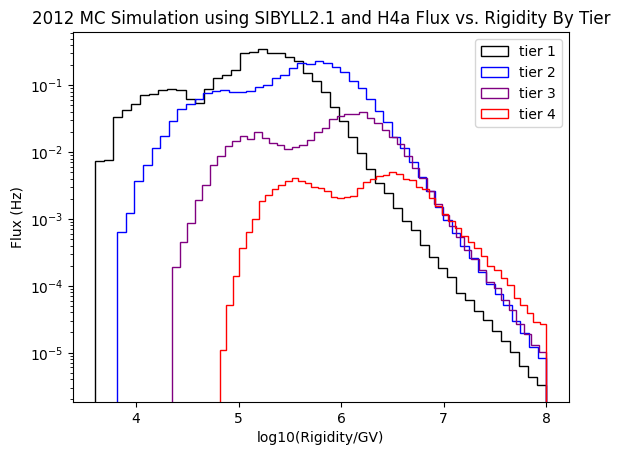

 Median(Log10(Rigidity)): 5.2 GV
 Median(Log10(Rigidity)): 5.62 GV
 Median(Log10(Rigidity)): 5.98 GV
 Median(Log10(Rigidity)): 6.23 GV


In [89]:
ax = plt.subplot(1, 1, 1)
(t1, binst1, patches1) = plt.hist(np.log10(t1rigidity_), bins=50, log=True, weights=t1weight_, histtype='step', color='black', label='tier 1')
(t2, binst2, patches2) = plt.hist(np.log10(t2rigidity_), bins=50, log=True, weights=t2weight_, histtype='step', color='blue', label='tier 2')
(t3, binst3, patches3) = plt.hist(np.log10(t3rigidity_), bins=50, log=True, weights=t3weight_, histtype='step', color='purple', label='tier 3')
(t4, binst4, patches4) = plt.hist(np.log10(t4rigidity_), bins=50, log=True, weights=t4weight_, histtype='step', color='red', label='tier 4')
plt.xlabel('log10(Rigidity/GV)')
plt.ylabel('Flux (Hz)')
plt.title('2012 MC Simulation using SIBYLL2.1 and H4a Flux vs. Rigidity By Tier')
plt.legend()
#ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

#Median Rigidity
print(f' Median(Log10(Rigidity)): {round(np.log10(t1median_), 2)} GV')
print(f' Median(Log10(Rigidity)): {round(np.log10(t2median_), 2)} GV')
print(f' Median(Log10(Rigidity)): {round(np.log10(t3median_), 2)} GV')
print(f' Median(Log10(Rigidity)): {round(np.log10(t4median_), 2)} GV')